<a href="https://colab.research.google.com/github/SERVIR-Amazonia/MANGLEE/blob/main/PAPER/MANGLEE_M3_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

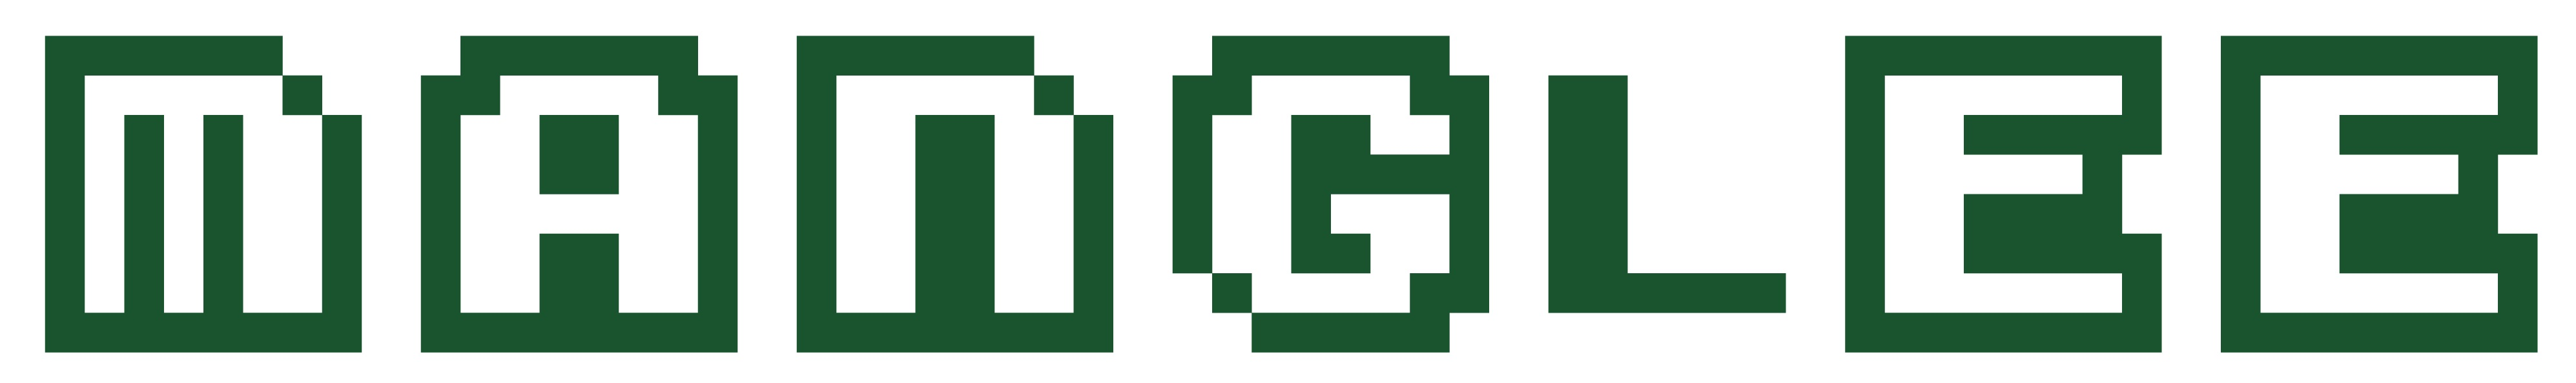

# **Módulo 3: Detección de Cambios en Cobertura de Manglar**
*Module 3: Change detection in mangrove cover*


---

Para realizar la detección MANGLEE utiliza produtos de los módulo 2, restando los raster de cobertura de dos periodos diferentes.
Si no se tiene mapas de cobertura se da una solución en la parte dos del modulo.

Este código ha sido adaptado por Lorena Caiza (ECOCIENCIA/SERVIR-Amazonia/CAMBIUM UVa)
Ultima modificación 15/05/2023
Los documentos, difusión y resultados los encontrars en: https://sites.google.com/view/mangleetrain/inicio

Licensed under a Creative Commons Attribution 4.0 license. (CC-BY).

#Carga las librerías

*Import libraries*



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline
!pip install -q geemap
import folium
import ee
import geemap
import ee.mapclient
from IPython.display import display

Active su cuenta de Google Earth Engine
*Active your account in GEE*

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=WNjyTzDtCH6nHVTkDj4hcmeL40hFqhlNmT0ReBLs4l4&tc=2UMKtli4Jv1hgz4jFnpX20pYRnVC0aVDyP-Nj8E5Zhk&cc=75rmE6og16OGqTY9HR_GEATrHJ2tWUnwSoxYW2KaTMg

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BUJpItzdkuNfcs_FlCgS8PpRugwwawxGaEZhXOLvwAiMinP6mCBqL4

Successfully saved authorization token.


## **1. Detección de cambios comparando dos mapas de cobertura**
-----
### Requisitos

*   Cuenta de Google Earth Engine
*   Asset de cobertura año 1 en GEE
*   Asset de cobertura año 2 en GEE

Ingrese dos raster de cobertura: uno del inicio del periodo y otro del final del periodo de análisis
* Cover_1 primer año
* Cover_2 segundo año

*Asegúrese que la clase manglar tenga el mismo valor de pixel en los raster*

In [ ]:
## Cargar los raster de diferentes años
cover_1 = ee.Image('projects/ee-lorenacaizamorales/assets/MANGLAR_2018_f');
cover_2 = ee.Image('projects/ee-lorenacaizamorales/assets/MANGLAR_2020_f');
#Detectar cambios entre coberturas
cambio = (cover_2.unmask(0)).subtract(cover_1.unmask(0)).reproject('EPSG:4326',scale=10).focal_mode()
mask = cambio.neq(0)
cambio = cambio.updateMask(mask)


In [ ]:
##Visualizar los resultados
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
Map.addLayer(cover_1,{'palette':['34BFDE'], 'min':1, 'max':1}, 'Cobertura 1er año')
Map.addLayer(cover_2,{'palette':['71F4B7'], 'min':1, 'max':1}, 'Cobertura 2do año')
Map.addLayer(cambio,{'palette':['red','#000000','green'], 'min':-1, 'max':1}, 'Cambios')
Map.addLayerControl()
Map

Para descargar el raster de cambios a su Drive asegúrese de que la descarga se inició en la ventana del Code Editor de GEE

In [ ]:
export = ee.batch.Export.image.toDrive(**{
  'image': cambio.toDouble(),
  'description': 'Cambios',
  'scale': 10,
  'maxPixels': 1e10
})
export.start()

# **2. Detección de Cambios en Cobertura de Manglar con una mascara**


---


Para realizar la detección MANGLEE utiliza produtos Sentinel 1 para detectar las perdidas a partir de mascara base. Es necesario tener una cuenta en Google Earth Engine y un Asset vectorial que delimite la zona de estudio previanmente se a cargado un ejemplo para el Manglar del Ecuador.


Ingrese la fecha  periodo de análisis en el formato 'YYYY-MM-dd'
* S1start_date
* S1end_date

In [ ]:
   S1start_date = ee.Date('2023-01-01')
   S1end_date =ee.Date('2023-01-31')


*Opcional: Si no tiene preferencia en las fechas el siguiente comando buscara las imágenes SAR disponibles del ultimo mes*


In [ ]:
from datetime import datetime
end = (ee.Date(datetime.now()).format('Y-M-d').getInfo())
S1end_date=ee.Date(end)
S1start_date = ee.Number(S1end_date.advance(-1, 'month').format('YYYY-MM-dd'))
S1start_date

Definir la zona de estudio personalida y la mascara de manglar para el análisis
* AOI = Ubicación de su Asset en GEE
* MAN = Mascara raster de Manglar

 *Asegurese de seleccionar la banda correcta en MAN.select(**'bandName'**).eq('valordelmanglarenelraster') y el valor del manglar en su mascara*

In [ ]:
#Cargue su poligono de interes como un Asset a GEE
AOI= ee.FeatureCollection('users/lorenacaizamorales/SERVIR/AOI_ECUADOR')

In [ ]:

#Cargue su mascara y mire sus bandas
MAN =ee.FeatureCollection('projects/ee-lorenacaizamorales/assets/MANGLEE/MAN_GYE_2022_10m')
MAN
MAN = MAN.filter(ee.Filter.neq('gridcode', None))\
                   .reduceToImage(**{'properties': ['gridcode'],
                                     'reducer': ee.Reducer.first()})
MAN
aoi=MAN

In [ ]:
Mask_MAN = MAN.select('first').eq(1)

Si no se tiene una mascara de Manglar se propone utilizar ESA WorldCover 10m

1.  'ESA/WorldCover/v100 para el 2020
2.  'ESA/WorldCover/v200 año 2021


In [ ]:
MAN=ee.ImageCollection('ESA/WorldCover/v200').first()
Mask_MAN=MAN.eq(95)
Map = geemap.Map(center=(-2.6, -80.0), zoom=8)
Map.addLayer(Mask_MAN)
Map

Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

## Detección de cambios
Aplicara una mascara para detectar los cambios con imagenes SAR, para visualización utiliza las imagenes opticas *Planet & NICFI Basemaps for Tropical Forest Monitoring - Tropical Americas*


In [ ]:
##///----------------------------------SAR Sentinel 1 -----------------------///
##//calcula los indices de vegetación SAR
def rfdi_fun(img):
   pwr = ee.Image(10).pow(img.divide(10)).set('system:time_start', img.get('system:time_start'));## // first convert to linear units (power)
   rfdi= pwr.select('VV').subtract(pwr.select('VH')).divide(pwr.select('VV').add(pwr.select('VH'))).rename('RFDI');
   VV_VH = img.select('VV').divide(img.select('VH')).rename('VV_VH');
   rvi = pwr.expression('4*VH/(VV+VH)',{'VH':pwr.select('VH'),'VV':pwr.select('VV')}).rename('RVI');
   return img.addBands(rfdi).addBands(VV_VH).addBands(rvi)

# Import and filter S1.
##// Carga la colección  Sentinel-1 C-band SAR Ground Range collection (log scale, VV, descending)
s1_All = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))# mostly is used in VV, I tried with VH but I had less bands
    .filter(ee.Filter.eq('instrumentMode', 'IW'))# default mode
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))# try for ascending or descending, but for Texas worked better DESCENDING
    .filterDate(S1start_date, S1end_date)
    .filterBounds(AOI)
    )
s1_All
S1All = (s1_All).map(rfdi_fun).median()
S1_C = ee.Image.cat([S1All.select(['VV_VH','RVI','RFDI'])]).clip(AOI).focalMean(30, 'square','meters');
S1_C
# Mascara Manglar
S1_C_Mask = S1_C.updateMask(Mask_MAN)
#Mascara perdida
LOSS_MAS= S1_C_Mask.select('VV_VH').gt(0.58)
S1_C_LOSS =S1_C_Mask.updateMask(LOSS_MAS)
#Visualización
s2 =(
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(S1start_date, S1end_date)
    .filterBounds(AOI).median()
    )
# Define los parametros de visualizacion y muestra la imagen SAR
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
classVis = {'min': 0, 'max': 1, 'palette':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']} ;
NICFI = (
    ee.ImageCollection('projects/planet-nicfi/assets/basemaps/americas')
    .filterDate('2023-01-01', '2023-12-31')
    .filterBounds(AOI).first()
    )
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0.05, "max": 6000, "gamma": 1.5}
visn = {"bands": ['R', 'G', 'B'], "min": 0.05, "max": 6000, "gamma": 1.5}
ndvi =s2.normalizedDifference(['B8', 'B4'])
Map.addLayer(NICFI,visn,'NIFCI-PRE')
Map.addLayer(s2,vis,'Sentinel 2')
Map.addLayer(ndvi,classVis, 'NDVI')
Map.addLayer(S1_C.select('VV_VH'),classVis,'VV_VH');
Map.addLayer(S1_C_Mask.select('VV_VH'),classVis,'VV_VH_Mask');
Map.addLayer(S1_C_LOSS.select('VV_VH'),{'min': 0.6, 'max': 1, 'palette':['#d63000']},'LOSS');
Map.addLayerControl()
Map

Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [ ]:
   S1start_date = ee.Date('2023-03-07')
   S1end_date =ee.Date('2023-03-31')

In [ ]:
##///----------------------------------SAR Sentinel 1 -----------------------///
##//calcula los indices de vegetación SAR
def rfdi_fun(img):
   pwr = ee.Image(10).pow(img.divide(10)).set('system:time_start', img.get('system:time_start'));## // first convert to linear units (power)
   rfdi= pwr.select('VV').subtract(pwr.select('VH')).divide(pwr.select('VV').add(pwr.select('VH'))).rename('RFDI');
   VV_VH = img.select('VV').divide(img.select('VH')).rename('VV_VH');
   rvi = pwr.expression('4*VH/(VV+VH)',{'VH':pwr.select('VH'),'VV':pwr.select('VV')}).rename('RVI');
   return img.addBands(rfdi).addBands(VV_VH).addBands(rvi)

# Import and filter S1.
##// Carga la colección  Sentinel-1 C-band SAR Ground Range collection (log scale, VV, descending)
s1_All = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))# mostly is used in VV, I tried with VH but I had less bands
    .filter(ee.Filter.eq('instrumentMode', 'IW'))# default mode
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))# try for ascending or descending, but for Texas worked better DESCENDING
    .filterDate(S1start_date, S1end_date)
    .filterBounds(AOI)
    )
s1_All
S1All = (s1_All).map(rfdi_fun).median()
S1_C = ee.Image.cat([S1All.select(['VV_VH','RVI','RFDI'])]).clip(AOI).focalMean(30, 'square','meters');
S1_C
# Mascara Manglar
S1_C_Mask = S1_C.updateMask(Mask_MAN)
#Mascara perdida
LOSS_MAS= S1_C_Mask.select('VV_VH').gt(0.58)
S1_C_LOSS =S1_C_Mask.updateMask(LOSS_MAS)
#Visualización
s2 =(
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(S1start_date, S1end_date)
    .filterBounds(AOI).median()
    )
# Define los parametros de visualizacion y muestra la imagen SAR
Map = geemap.Map(center=(-2.6, -80.0), zoom=10)
classVis = {'min': 0, 'max': 1, 'palette':['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']} ;
NICFI = (
    ee.ImageCollection('projects/planet-nicfi/assets/basemaps/americas')
    .filterDate('2023-01-01', '2023-12-31')
    .filterBounds(AOI).first()
    )
vis = {"bands": ['B4', 'B3', 'B2'], "min": 0.05, "max": 6000, "gamma": 1.5}
visn = {"bands": ['R', 'G', 'B'], "min": 0.05, "max": 6000, "gamma": 1.5}
ndvi =s2.normalizedDifference(['B8', 'B4'])
Map.addLayer(NICFI,visn,'NIFCI-PRE')
Map.addLayer(s2,vis,'Sentinel 2')
Map.addLayer(ndvi,classVis, 'NDVI')
Map.addLayer(S1_C.select('VV_VH'),classVis,'VV_VH');
Map.addLayer(S1_C_Mask.select('VV_VH'),classVis,'VV_VH_Mask');
Map.addLayer(S1_C_LOSS.select('VV_VH'),{'min': 0.6, 'max': 1, 'palette':['#d63000']},'LOSS');
Map.addLayerControl()
Map

Map(center=[-2.6, -80.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…